In [ ]:
"""
Created on July, 2024

@author: Weronika Golletz
@author: Czcibor Ciostek

Womanium Quantum + AI Project
"""

# 2D transverse-field Ising model

In this notebook, we analyze the two-dimensional (2D) transverse-field Ising model with $N \times M$ spins. We focus on how the global magnetization changes over time. To simulate the system's dynamics, we use the Classiq Python SDK. The connecitons are adjusted to the ones in the ibm_fez hardware.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  tex-common tex-gyre texlive-base texlive-binaries texlive-fonts-recommended
  texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-fram

In [ ]:
!pip install -U classiq

In [ ]:
import classiq
from classiq.execution import ExecutionPreferences
from classiq.execution import ExecutionSession

In [ ]:
from classiq import *

In [ ]:
classiq.authenticate()

In [3]:
# Plots settings
WIDTH = 5
HEIGHT = 3

SMALLER_SIZE = 11
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rcParams['text.usetex'] = True
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

In [4]:
# Parameters of the Suzuki-Trotter decomposition
REPETITIONS = 5000
N = 5 # number of spins in row
M = 5 # number of spins in column

# Parameters of the system
CONNECTIONS = [[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,10],[10,11],[11,12],[12,13],[13,14],[14,15],
               [3,16],[7,17],[11,18],[15,19],[20,21],[21,22],[22,23],[23,24],[16,23]]


Js = [1]*len(CONNECTIONS)   # coupling constants
hs = [-3]*(N*M)  # external magnetic field

In [ ]:
def get_repetitions():
  """
  Just returns the global variable repetitions;
  allows us to control the 'repetitions' parameter
  as a function variable.
  """
  return REPETITIONS

def get_connections():
  """
  Just returns the global variable connections -- which spins are coupled;
  allows us to control the 'connections' parameter
  as a function variable.
  """
  return CONNECTIONS

def get_Js():
  """
  Just returns the global variable Js -- coupling between spins;
  allows us to control the 'Js' parameter
  as a function variable.
  """
  return Js

def get_hs():
  """
  Just returns the global variable hs -- external magnetic field;
  allows us to control the 'hs' parameter
  as a function variable.
  """
  return hs

def get_N():
  """
  Just returns the global variable N -- number of spins in a row;
  allows us to control the 'N' parameter
  as a function variable.
  """
  return N

def get_M():
  """
  Just returns the global variable M --  number of spin in a column;
  allows us to control the 'M' parameter
  as a function variable.
  """
  return M

def mz_state(basis):
    """
    Calculate the magnetization of a given state in the basis.

    Input
    -----
    basis (str): a state from the basis
    N (int): number of spins

    Output
    ------
    mz (int): magnetization of a given state
    """
    mz = 0
    for id in range(len(basis)):
        mz += (1-2*int(basis[id]))
    return mz

def mz_total(basis,state,N_tot):
    """
    Calculate the total magnetization for a given state.

    Input
    -----
    basis (str): computational basis for N=4 spins
    state (np.array): the state in which the magnetization is calculated
    N (int): number of spins

    Output
    ------
    (float): the total magnetization of a system
    """
    mz_total = 0
    for jd in range(len(basis)):
        mz_total += state[jd] * mz_state(basis[jd])
    return mz_total/N_tot

In [ ]:
# Defining the Hamiltonian
def get_hamiltonian(connections,N,M,J,h):
  """
  Generate the 2D Ising Hamiltonian for NxM spins for given connections.
  The external field 'h' can varied from site to site,
  and the coupling strength 'J' between spins can be different.

  Input
  -----
  connections (list): list of connections between spins
  N (int): number of rows
  M (int): number of columns
  J (list): interaction strength for given connections
  h (list): transverse field strength

  Output
  ------
  hamiltonian (np.array): Hamiltonian for NxM spins
  """
  hamiltonian = []

  for (id,connection) in enumerate(connections):
      term_zz = [Pauli.I] * (N*M)
      term_zz[connection[0]] = Pauli.Z
      term_zz[connection[1]] = Pauli.Z
      hamiltonian.append(PauliTerm(term_zz, J[id]))

  for id in range(N*M):
      term_x = [Pauli.I] * (N*M)
      term_x[id] = Pauli.X
      hamiltonian.append(PauliTerm(term_x, h[id]))

  return hamiltonian

In [ ]:
@qfunc
def main(time:CReal,qreg: Output[QArray]):
    # Parameters of the system
    N = get_N() # number of spins in row
    M = get_M() # number of spins in column
    Js = get_Js()
    hs = get_hs()
    CONNECTIONS = get_connections()

    # Parameters of the system's dynamics
    REPETITIONS = get_repetitions()
    order = 1

    # Create a qcircuit
    allocate(N*M,qreg) # initial state |0,0,0,...>

    suzuki_trotter(
        get_hamiltonian(CONNECTIONS,N,M,Js,hs),
        evolution_coefficient=time,
        repetitions=REPETITIONS,
        order=order,
        qbv=qreg,
    )

### Different times; repetitions=15, shots=5000 (final results)

In [ ]:
times = np.arange(0.0,3.,0.05)
N_tot = N*M

magnetizations_cl = np.zeros(len(times))

# Parameters related to qcircuit and measurement
REPETITIONS = 15
shots = 5000

qcircuit = create_model(main)
quantum_program = synthesize(qcircuit)

# ExecuteSession for symbolic parameters
exe_session = ExecutionSession(quantum_program,
                                ExecutionPreferences(
                                num_shots=shots, job_name=f"suzuki-trotter", random_seed=767
                              ))
# show(quantum_program)

for (id,time) in enumerate(times):
  results = exe_session.sample({"time":time})

  # calculate magnetization
  data = results.counts
  state = [v/shots for v in data.values()]
  basis = list(data.keys())
  magnetizations_cl[id] = mz_total(basis,state,N_tot)

In [ ]:
magnetizations_cl

array([ 1.00000e+00,  9.54272e-01,  8.26544e-01,  6.28784e-01,
        3.91328e-01,  1.28992e-01, -1.36672e-01, -3.75232e-01,
       -5.70272e-01, -6.99424e-01, -7.66368e-01, -7.56768e-01,
       -6.91600e-01, -5.70208e-01, -4.10000e-01, -2.38736e-01,
       -6.00000e-02,  1.03040e-01,  2.44800e-01,  3.42176e-01,
        4.12128e-01,  4.38080e-01,  4.18000e-01,  3.75952e-01,
        3.01152e-01,  2.06016e-01,  1.05504e-01,  1.59680e-02,
       -7.67680e-02, -1.47424e-01, -1.87344e-01, -2.19056e-01,
       -2.17408e-01, -2.09008e-01, -1.76256e-01, -1.34496e-01,
       -8.39840e-02, -3.48640e-02,  1.16960e-02,  4.60960e-02,
        7.88800e-02,  9.36800e-02,  9.44320e-02,  8.51840e-02,
        6.82880e-02,  6.70080e-02,  3.88640e-02,  1.44640e-02,
       -5.87200e-03, -2.97120e-02, -4.39200e-02, -4.65600e-02,
       -5.03200e-02, -5.19520e-02, -3.72640e-02, -2.56800e-02,
       -1.82400e-02,  2.08000e-04,  1.24800e-02,  2.45600e-02])

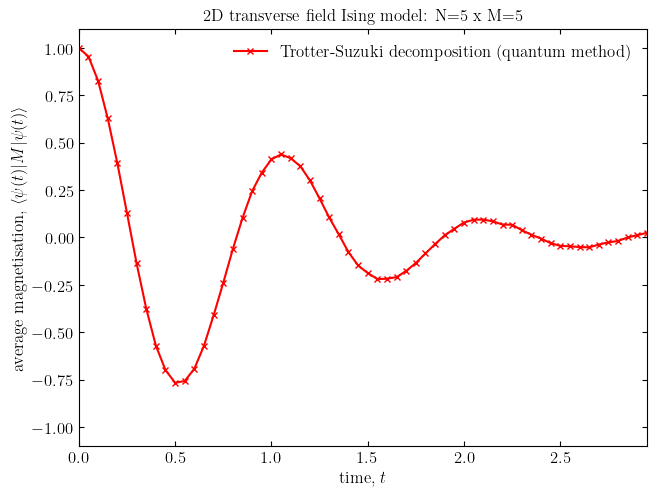

In [6]:
# plot
# plt.plot(times,magnetizations_exact,label=f"Exact evolution")
# plt.plot(t_maxs,magnetizations_TS,label=f"Trotter-Suzuki decomposition (without Classiq)", lw=0, marker='o',color='k',markersize=5)
plt.plot(times,magnetizations_cl,label=f"Trotter-Suzuki decomposition (quantum method)", marker='x',color='red',markersize=5)
plt.xlim(0,times[-1])
plt.ylim(-1.1,1.1)
plt.tick_params(direction='in')
plt.tick_params(top=True, right=True, which='major')
plt.legend(frameon=False)
plt.xlabel(r'time, $t$')
plt.ylabel(r"average magnetisation, $\langle \psi(t)| M | \psi(t) \rangle$")
plt.title(f"2D transverse field Ising model: N={N} x M={N}")
plt.tight_layout(pad=0.1, w_pad=0.4, h_pad=0.5)
# plt.savefig("name.png",dpi=300)
# plt.savefig("name.svg")
plt.show()